In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/raw.csv')

In [4]:
df.shape

(3528, 142)

In [5]:
esm_columns = [col for col in df.columns if "ESM" in col and col != "filter_ESMprotocolvalid_."]
esm_data = df[esm_columns]
esm_data = esm_data.loc[:,esm_data.isna().sum() <= len(esm_data)*0.75]
esm_data.fillna(0.,inplace=True)
esm_no_date_pd = esm_data.select_dtypes(exclude=["O","object"])
esm_no_date = esm_no_date_pd
esm_no_date_columns = esm_no_date.columns

In [6]:
def plot_pain_regions(data,ax=None,title = None):
    upper_left = data["ESM_ABDPAIN_LHR"].sum()
    upper_middle = data["ESM_ABDPAIN_EGR"].sum()
    upper_right = data["ESM_ABDPAIN_RHR"].sum()

    middle_left = data["ESM_ABDPAIN_RLR"].sum()
    middle_middle = data["ESM_ABDPAIN_UR"].sum()
    middle_right = data["ESM_ABDPAIN_LLR"].sum()

    bottom_left = data["ESM_ABDPAIN_RIR"].sum()
    bottom_middle = data["ESM_ABDPAIN_HR"].sum()
    bottom_right = data["ESM_ABDPAIN_LIR"].sum()

    regions = [[upper_left,upper_middle,upper_right],
          [middle_left,middle_middle,middle_right],
          [bottom_left,bottom_middle,bottom_right]]
    regions = np.array(regions)
    regions = np.fliplr(regions)
    regions_ = []
    for li in regions:
        for el in li:
            regions_.append(el)
    regions = np.array(regions_)

    plt.rcParams["axes.grid"] = False
    if ax == None:
        fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(plt.imread("torso.jpg"))

    normal = pl.Normalize(regions.min(), regions.max())
    colors = pl.cm.RdYlGn_r(normal(regions))

    x0 = 325
    x=x0
    y = 550
    step = 120
    for obj in colors:
        ax.add_patch(patches.Rectangle((x,y),step,step,alpha=0.5,facecolor=obj))
        x+=120
        if x >= x0+step*3:
            y += step
            x = x0
    if title == None:
        ax.title.set_text('Pain by region (counts)');
    else:
        ax.title.set_text(title);

In [7]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import contingency_matrix
import seaborn as sns
import pylab as pl
import matplotlib.patches as patches

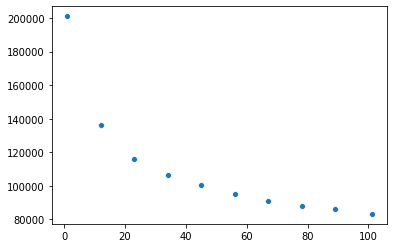

In [8]:
esm_no_date_pd_ss = StandardScaler().fit_transform(esm_no_date_pd)

inertia = []
range_ = np.int32(np.linspace(1,101,10))
for k in range_:
    clu = KMeans(k,random_state=42,init="random")
    clu.fit(esm_no_date_pd_ss)
    inertia.append(clu.inertia_)

sns.scatterplot(range_,inertia)

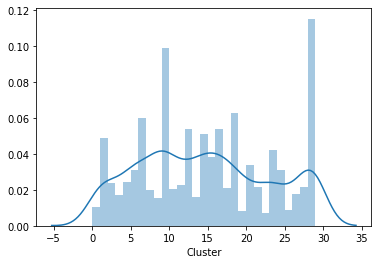

In [9]:
k=30
clu = KMeans(k,init="random")
esm_clu = esm_data.copy()
esm_clu["Cluster"] = clu.fit_predict(esm_no_date_pd_ss)
sns.distplot(esm_clu["Cluster"],bins = [el for el in range(0,k)])

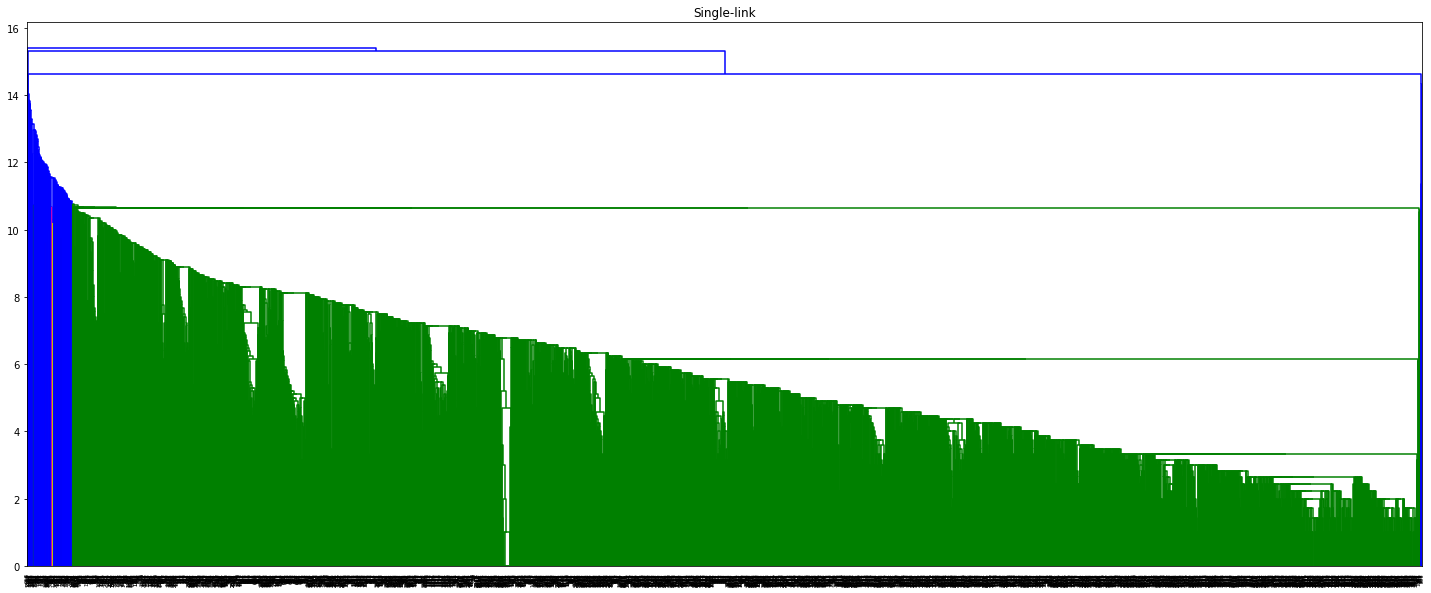

In [127]:
Z = linkage(esm_no_date_pd, 'single')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z,labels=esm_no_date_pd.index)
plt.title("Single-link")
plt.show()

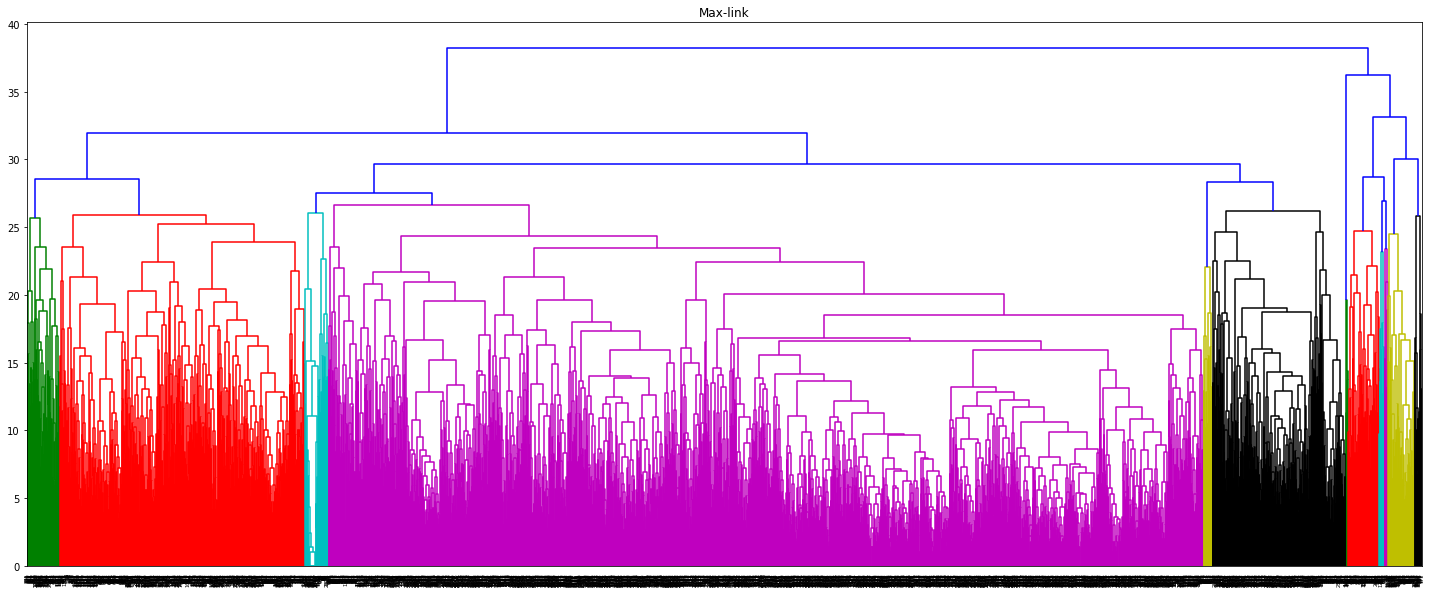

In [128]:
Z = linkage(esm_no_date_pd, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z,labels=esm_no_date_pd.index)
plt.title("Max-link")
plt.show()

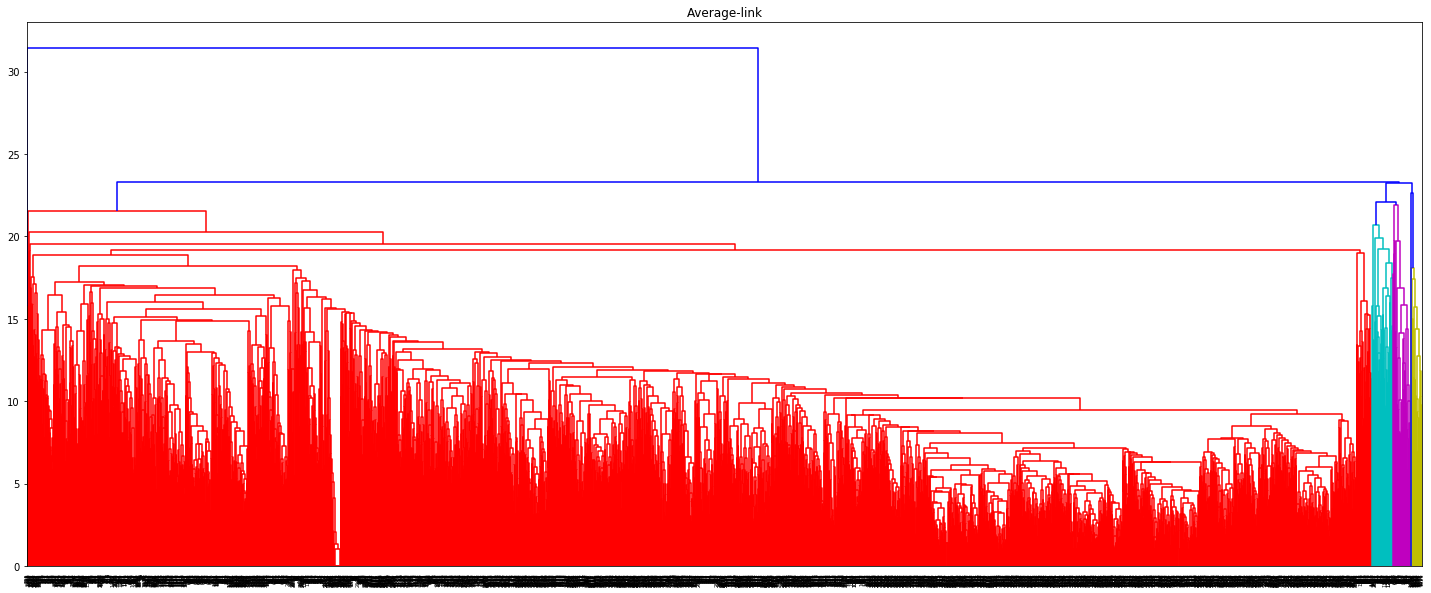

In [129]:
Z = linkage(esm_no_date_pd, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z,labels=esm_no_date_pd.index)
plt.title("Average-link")
plt.show()

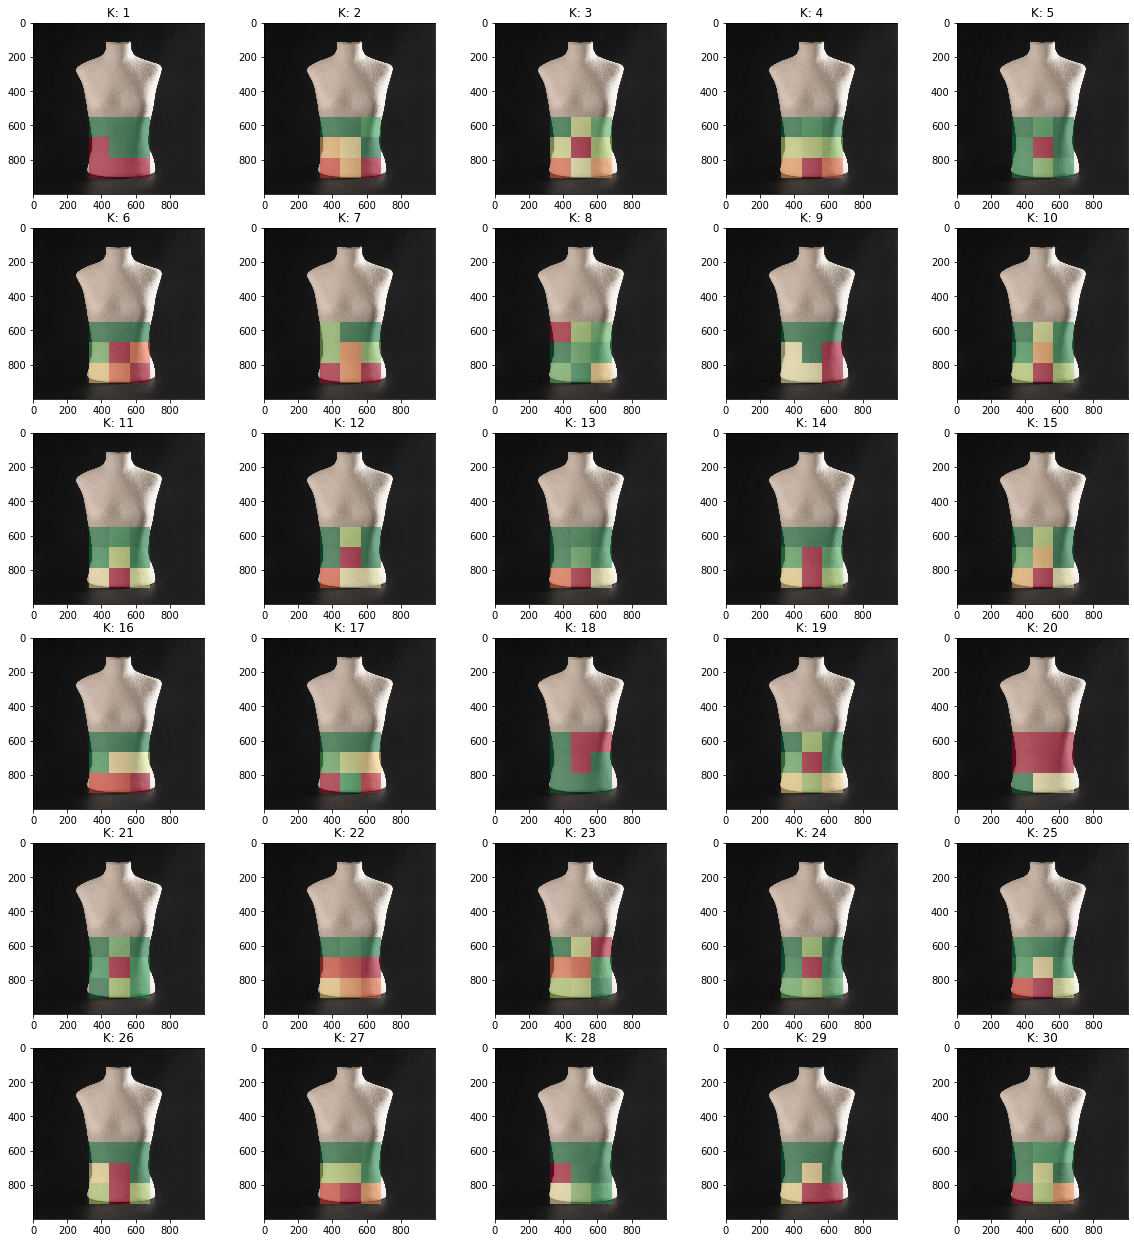

In [10]:
bins = [el for el in range(0,11)]

fig , ax = plt.subplots(int(k/5),5,figsize=(20,22))
for k_ in range(0,k):
    t = "K: "+str(k_+1)
    plot_pain_regions(esm_clu[esm_clu["Cluster"] == k_],ax=ax.reshape(-1)[k_],title=t)

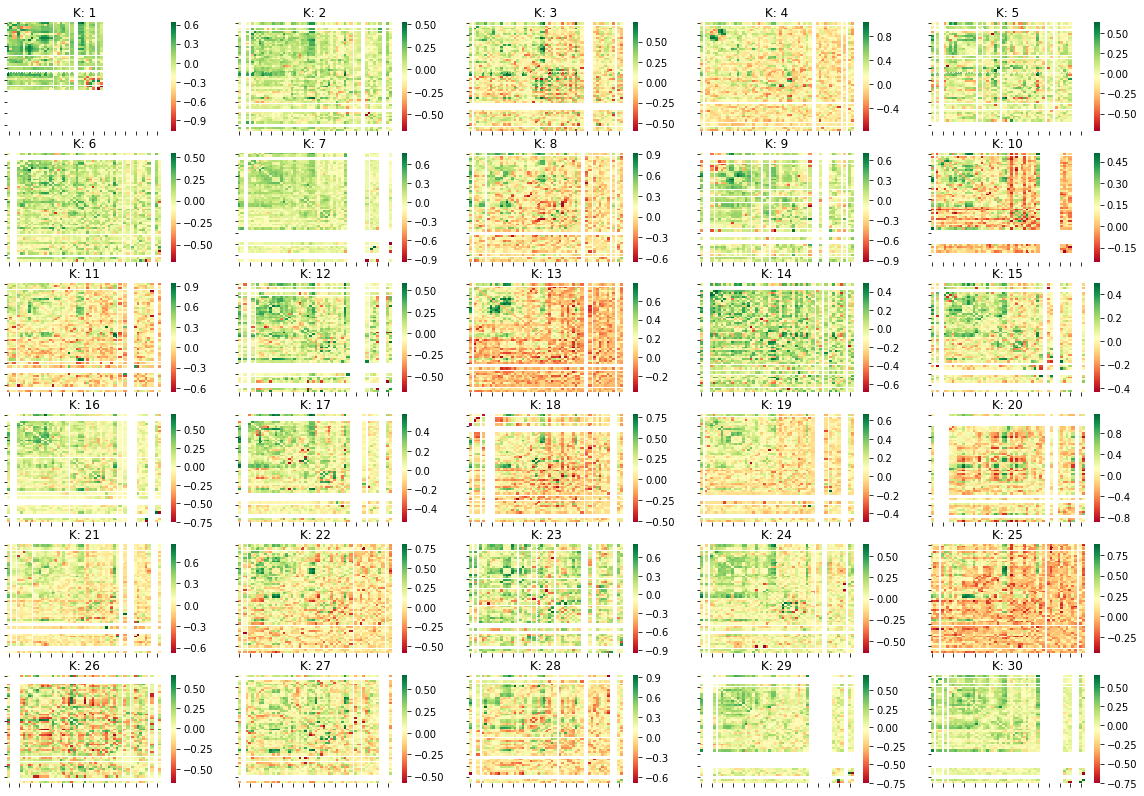

In [11]:
fig , ax = plt.subplots(int(k/5),5,figsize=(20,14))
for k_ in range(0,k):
    a = ax.reshape(-1)[k_]
    cor = esm_no_date_pd.corr()
    cor_ = cor - esm_data[esm_clu["Cluster"]==k_].corr()
    sns.heatmap(cor_,cmap=pl.cm.RdYlGn,ax=a,annot=False)
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_title("K: "+str(k_+1))

In [134]:
from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
from sklearn import datasets

#import iris dataset from sklearn library
iris =  datasets.load_iris();

#get the iris data. It has 4 features, 3 classes and 150 data points.
data = iris.data

"""!
The pyclustering library clarans implementation requires
list of lists as its input dataset.
Thus we convert the data from numpy array to list.
"""
data = data.tolist()

#get a glimpse of dataset
print("A peek into the dataset : ",data[:4])


"""!
@brief Constructor of clustering algorithm CLARANS.
@details The higher the value of maxneighbor, the closer is CLARANS to K-Medoids, and the longer is each search of a local minima.
@param[in] data: Input data that is presented as list of points (objects), each point should be represented by list or tuple.
@param[in] number_clusters: amount of clusters that should be allocated.
@param[in] numlocal: the number of local minima obtained (amount of iterations for solving the problem).
@param[in] maxneighbor: the maximum number of neighbors examined.        
"""
clarans_instance = clarans(data, 3, 6, 4);

#calls the clarans method 'process' to implement the algortihm
(ticks, result) = timedcall(clarans_instance.process);
print("Execution time : ", ticks, "\n");

#returns the clusters 
clusters = clarans_instance.get_clusters();

#returns the mediods 
medoids = clarans_instance.get_medoids();


print("Index of the points that are in a cluster : ",clusters)
print("The target class of each datapoint : ",iris.target)
print("The index of medoids that algorithm found to be best : medoids")

ModuleNotFoundError: No module named 'pyclustering'